#  Create a MIRI simulation using a FITS file

Notebook by Karl Gordon (kgordon@stsci.edu) based on MIRISim docs and generous help from various people

**NOTE** this notebook must be started within  the mirisim conda environment. This is a requirement for using MIRISim, and installation instructions can be found [here](https://wiki.miricle.org/Public/MirisimInstallation).

### Steps in this notebook:

1. Create a Scene
2. Initialise the simulation parameters
3. run the simulation
4. examine some of the outputs.  

In [1]:
# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation

#other things to be used
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

import matplotlib.pyplot as plt    # to display images
from matplotlib import colors,cm
%matplotlib inline                 

/home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Create a Scene

In [2]:
from mirisim import config_parser as c  # SimConfig, SimulatorConfig, SceneConfig
from mirisim import skysim

# See MIRISim documentation for details to create a scene
# We prepare the scene we want to model
# background = skysim.Background(level='high', gradient=0., pa=0.0, centreFOV=(0., 0.)) # High level background

# Creation of the scene from FITS file:
# fits_ext: the index of the fits file extension where the data cube is stored. 0 index by default if you omit the keyword.
# center: If 'yes', the input file is centered anyway, and astrometry ignored.
# method: grid interpolation method selected (0, 1 or 2, default is 1).
#       - 0: interpolation with no flux conservation rebinning (fast, inaccurate)
#       - 1: cumulative trapezoid rule rebinning with interpolation over entire 3D cube (default)
#       - 2: cumulative trapezoid rule rebinning with interpolation per each column (scales with the number of pixels - and can be very slow)
# conserve: how the flux is conserved (full or wave, default is wave).
#       - 'wave': interpolate wavelength grid only to conserve flux (you do not conserve flux over the spatial grid)
#       - 'full': full flux conserving interpolation over the full grid of ra, dec, wav
cube = skysim.Skycube('./scenes/dither_illustration_m101_irac8_SED.fits', fits_ext=0, center='yes', method=0, conserve="wave")
# scene_config = c.SceneConfig.makeScene(loglevel=1, background=background, targets=[cube]) #For Background observations: targets=[]. remove background=background for no background.
scene_config = c.SceneConfig.makeScene(loglevel=1, targets=[cube])

2022-03-14 14:14:34,567 - INFO - Initializing Skycube
2022-03-14 14:14:34,569 - INFO - Loading external scene from FITS ./scenes/dither_illustration_m101_irac8_SED.fits
2022-03-14 14:14:36,010 - INFO - Aligning the centre of the fits file with the centre of the scene


### Export the scene to an ini file and FITS

The scene can also be exported to an ini file (for future use), or a FITS file to be visualised.

Exporting to a FITS file requires specifing a number of aditional parametrs such as the Field of view, required spectral sampling, etc. They're described in more detail below. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes)

**NOTE**: export to fits currently (8/Feb/2017) doesn't work properly



In [3]:
## export to ini file

os.system('rm IMA_example_scene.ini')
scene_config.write('IMA_example_scene.ini')

## Initialise the Simulation Parameters

In [4]:
sim_config = SimConfig.makeSim(
    name = 'ima_simulation',    # name given to simulation
    scene = 'IMA_example_scene.ini', # name of scene file to input
    rel_obsdate = 0.0,          # relative observation date (0 = launch, 1 = end of 5 yrs)
    POP = 'IMA',                # Component on which to center (Imager or MRS)
    ConfigPath = 'IMA_FULL',  # Configure the Optical path (MRS sub-band)
    Dither = True,             # Don't Dither
    StartInd = 1,               # start index for dither pattern
    NDither = 4,                # number of dither positions 
    DitherPat = 'mirisim_dithers/miri_imaging_f770w_cycling4_start1_small.dat', # dither pattern to use
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 2,          # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 5,             # [NOT USED HERE]
    ima_exposures = 1,          # number of exposures
    ima_integrations = 1,       # number of integrations
    ima_frames = 5,             # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',          # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'F770W',          # Imager Filter to use
    readDetect = 'FULL'         # Portion of detector to read out
)

### Export the simulation setup to a file

In [5]:
os.system('rm IMA_simulation.ini')
sim_config.write('IMA_simulation.ini')

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.

the last step is to setup the defaults for internal things like CDPs.

In [6]:
simulator_config = SimulatorConfig.from_default()


mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()

2022-03-14 14:14:36,052 - INFO - MIRISim version: 2.4.2
2022-03-14 14:14:36,054 - INFO - MIRI Simulation started.
2022-03-14 14:14:36,055 - INFO - Output will be saved to: 20220314_141436_mirisim
2022-03-14 14:14:36,056 - INFO - Storing configs in output directory.
2022-03-14 14:14:36,059 - INFO - Storing dither pattern in output directory.
2022-03-14 14:14:36,487 - WARNING - Environment variable CDP_DIR is not set. Will look up / store CDP files at ./CDP
2022-03-14 14:14:36,549 - INFO - Reading cosmic ray properties from parameter file /home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/miri/simulators/scasim/cosmic_ray_properties.py
2022-03-14 14:14:36,558 - INFO - Reading detector properties from parameter file /home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/miri/simulators/scasim/detector_properties.py
2022-03-14 14:14:36,602 - INFO - Setting up simulated Observation, with following settings:
2022-03-14 14:14:36,603 - INFO - Configuration Pat

2022-03-14 14:15:23,290 - INFO - Reading 'READNOISE' model from './CDP/MIRI_FM_MIRIMAGE_FAST_READNOISE_07.01.00.fits'
2022-03-14 14:15:23,399 - INFO - Creating exposure_data with 1280 rows x 1032 columns plus 5 groups and 1 ints.
2022-03-14 14:15:23,680 - INFO - Simulating 1 integration.
2022-03-14 14:15:23,694 - WARNING - ***Input flux array contains 129991 negative values.
2022-03-14 14:15:23,763 - INFO - Simulating 5 groups for integration 1.
2022-03-14 14:15:25,441 - INFO - Adding the DARK calibration from ./CDP/MIRI_FM_MIRIMAGE_FAST_DARK_06.01.00.fits
2022-03-14 14:15:25,523 - INFO - Correcting nonlinearity from MIRI_FM_MIRIMAGE_LINEARITY_06.02.00.fits
2022-03-14 14:15:25,723 - INFO - Output subarray undefined or FULL. SUBSTRT=(1,1), SUBSIZE=(1032,1024)
2022-03-14 14:15:25,724 - INFO - WCS keywords defined as CRPIX1=0, CRPIX2=0
2022-03-14 14:15:30,121 - INFO - Exposure time 13.88s (duration 14.93s) 
2022-03-14 14:15:30,319 - INFO - Wrote detector image: 20220314_141436_mirisim/det

2022-03-14 14:16:23,948 - INFO -   Detector readout mode is FAST (samplesum=1, sampleskip=0, nframe=1, groupgap=0) 
  with 1 integrations and ngroups=5 defined explicitly.
  Detector subarray mode is FULL.
2022-03-14 14:16:23,949 - INFO - Detector temperature = 6.70 K (which affects dark current and read noise).
2022-03-14 14:16:23,950 - INFO - Cosmic ray environment is SOLAR_MIN. (No change.)
2022-03-14 14:16:23,952 - INFO - Simulation control flags:
	Quantum efficiency simulation turned OFF.
	Poisson noise simulation turned ON.
	Read noise simulation turned ON.
	Reference pixels simulation turned ON.
	Bad pixels simulation turned ON.
	Dark current simulation turned ON.
	Flat-field simulation turned ON.
	Amplifier bias and gain turned ON.
	Detector non-linearity effects turned ON.
	Detector drift effects turned ON.
	Detector latency effects turned ON.
2022-03-14 14:16:23,953 - WARNING - ***Illumination map of size 1024 x 1032 is too large! Truncating to detector size of 1024 x 1024 pi

## Examine some of the results

Now that the MIRISim simulation has completed, lets examine the results. 


The first thing to note is that the outputs are placed in a date-labelled directory taking the form  <code> YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

In [7]:
outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the outputdirectory are:\n{}'.format(directories))
print('The files in the outputdirectory are:\n{}'.format(files))

The subdirectories in the outputdirectory are:
['illum_models', 'det_images']
The files in the outputdirectory are:
['mirisim.log', 'simulation.ini', 'scene.ini', 'simulator.ini', 'miri_imaging_f770w_cycling4_start1_small.dat']


The files contain the log which was also output to the terminal (<code> mirisim.log</code>) and copies of the .ini files used (or created from python inputs) to create the simulation. These versions of the .ini files can be used to re-create the run of the simulation

The directories contain various outputs of MIRISim:

* **<code> illum_models </code>** houses FITS images of the illuminations sent to the detector (sent to SCAsim - the simulator of the Sensor Chip Assembly).  This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position
* **<code> det_images </code>** houses FITS images of the final outputs of MIRISim. These detector images have all of the detector effects and noise incorporated. The number of detector images should be the same as the number of illumination models. 

The headers of the detector images are formatted for ingest into the JWST pipeline. 

Below is a small code snippet used to draw the images.  it needs to be run, but doesn't produce any output directly (it's called later to show the output images)

In [8]:
def show_outputs(MIRISim_outputdir,output_type):
    '''
    plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    '''
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    

    hdu_index = 1
    if len(hdulist[hdu_index].data.shape) > 3:
        integ,frames,nx,ny = hdulist[hdu_index].data.shape
        image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        
        
    else:
        image = hdulist[hdu_index].data[0,:,:]
              
    norm = colors.LogNorm(image.mean() + 0.5 * image.std(), image.max(), clip=True)   
    plt.imshow(image,origin = 'lower', cmap = cm.viridis,interpolation = 'nearest',norm = norm)
    plt.title('{}'.format(infits.split('/')[-1]))
    plt.xlabel("'RA' Direction")
    plt.ylabel("'DEC' Direction")


    plt.colorbar()



### Viewing an illumination model

Below shows an example of an output illumination model

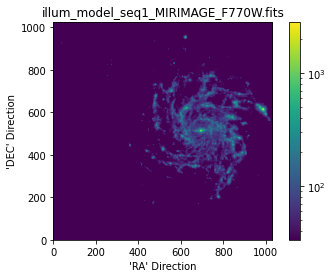

In [9]:
show_outputs(outputdir,'illum_models')


## Viewing the final detector image

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready.  Below an example image of the last frame of the last integration is shown. The units are <code>DN</code>.

Additionally, below the FITS header information for the SCIENCE extension is listed

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                    5                                                  
NAXIS4  =                    1                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
                                                                                
        Information about the coordinates in the file                           
                            

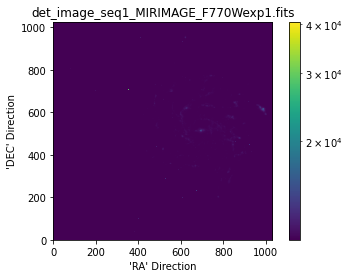

In [10]:
show_outputs(outputdir,'det_images')

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
hdulist[1].header